In [1]:
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Function
from skimage.feature import peak_local_max
from torchvision import transforms
import pickle
from torchdiffeq import odeint_adjoint as odeint
from scipy.integrate import solve_ivp
device = torch.device('cpu')

In [2]:
%run Supporting_Function.py
%run Ploting_Function_Fly.py
%run ODE_Func.py
%run GaussianFunc_noGrad.py
%run GaussianFunc_full.py
%run GaussianFunc_ChevMetric.py

In [6]:
class GaussianFunc_DualMetric(nn.Module):

  def __init__(self, dim = 2, param_M = {'nhidden_M' : 8, 'nlayer_M' : 1}, param_V = {'nhidden_P' : 8, 'n_V' : 2}, param_C = {'n_fc1' : 8 , 'n_fc2' : 16}):
    super(GaussianFunc_DualMetric, self).__init__()

    self.param_M = param_M
    self.param_V = param_V
    self.param_C = param_C

    nhidden_M = param_M['nhidden_M']
    nlayer_M = param_M['nlayer_M']
    nhidden_P = param_V['nhidden_P']

    n_fc1 = param_C['n_fc1']
    n_fc2 = param_C['n_fc2']

    self.n_V = param_V['n_V']
    self.ndim = dim
    self.potential_list = nn.ModuleList([])

    self.th = nn.Tanh() 
    self.sg = nn.Sigmoid()
    self.softplus = nn.Softplus(100)
    self.elu = nn.ELU(inplace = True)
    self.relu = nn.ReLU(inplace = True)

    self.metric_list = nn.ModuleList([nn.Linear(dim, nhidden_M)])
    for i in range(nlayer_M):
      self.metric_list.append(nn.Linear(nhidden_M, nhidden_M))
    self.metric_list.append(nn.Linear(nhidden_M, 2))

    # self.dout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(2, n_fc1)
    self.fc2 = nn.Linear(n_fc1, n_fc2)
    self.fc3 = nn.Linear(n_fc2, 1)

    for i in range(self.n_V):
      self.potential_list.append(nn.Linear(dim, nhidden_P))
      self.potential_list.append(nn.Linear(nhidden_P, nhidden_P, bias = False))
      self.potential_list.append(nn.Linear(nhidden_P, 1, bias = False))

  def softSig(self, input):
    Amp = 0.3
    slope = 2
    output = 1 + torch.log(slope*self.softplus(input) + 1) + torch.tanh(-1*slope*self.softplus(-1*input))
    output = Amp*output
    return output

  def metric_nn(self, x):
    out = self.metric_list[0](x)
    out = self.elu(out)
    
    for i, nlayer in enumerate(self.metric_list[1:-1]):
      out = nlayer(out)
      out = self.elu(out)
    
    out = self.metric_list[-1](out)
    out = self.softSig(out)
    return out

  def switch(self, x):
    out = self.elu(self.fc1(x))
    out = self.elu(self.fc2(out))

    out = self.fc3(out)
    out = self.sg(out)
    return out

  def metric(self, x):
    temp_dim = self.metric_nn(x).shape

    eigval = self.metric_nn(x)
    Id = (torch.eye(2)).repeat(temp_dim[:-1] + (1,1))
    D = torch.mul(eigval.unsqueeze(1), Id)

    scale = self.switch(x)
    # scale = torch.ones(x.shape)
    P_1 = 0.5*torch.tensor([[-1, 1], [1, 1]]).float()
    P_1 = torch.mul(scale.unsqueeze(1), P_1)

    P_2 = torch.tensor([[1, 0], [0, 1]]).float()
    P_2 = torch.mul(1-scale.unsqueeze(1), P_2)
    
    P = P_1 + P_2
    P_inv = torch.inverse(P)

    PD = torch.matmul(P, D)
    PDP = torch.matmul(PD, P_inv)
    return PDP

  def potential(self, num, x, return_all= False):
    size = 3
    start = size*num
    end = size*(num+1)
    layers_V = self.potential_list[start:end]
    self.last_layers = layers_V

    out = layers_V[0](x)
    out = torch.pow(out, 2)
    out1 = out

    out = layers_V[1](out)
    out = torch.exp(out)
    out2 = out

    out = layers_V[-1](out)
    out3 = out

    if return_all:
      return out1, out2, out3 
    else:
      return out3

  def gradient(self, num, x):
    f1,f2,f3 = self.potential(num, x, True)
    layers_V = self.last_layers

    W3 = layers_V[-1].weight.data
    grad = W3

    W2 = layers_V[1].weight.data
    f2_prime = f2
    grad = torch.mm(grad*f2_prime, W2)

    W1 = layers_V[0].weight.data
    f1_prime = 2*layers_V[0](x)
    grad = torch.mm(grad*f1_prime, W1)
    return grad

  def total_grad(self, x):
    grad = self.gradient(0, x)
    for i in range(1,self.n_V):
      grad = grad + self.gradient(i, x)
    grad = grad/self.n_V
    return grad

  def total_V(self,x):
    out = self.potential(0,x)
    for i in range(1,self.n_V):
      out = out + self.potential(i,x)
    out = out/self.n_V
    return out

  def forward(self, x):
    grad = self.total_grad(x).unsqueeze(2)
    mag = self.metric(x)
    out = torch.matmul(mag, grad).squeeze()
    return out

In [14]:
#@title Extract Data 
data_type = 'Bcd'
infile = open('Gap_genes_2dspace_flow_' + data_type + '.obj','rb')
H1, H2, H1dot, H2dot = pickle.load(infile)
infile.close()

Hdot = np.ma.stack([H1dot, H2dot], 2)
H_coord = np.ma.stack([H1, H2], 2)

V1, N1 = extractData(H1dot, H1)
V2, N2 = extractData(H2dot, H2)

N = np.concatenate((N1, N2), 1)
V = np.concatenate((V1, V2), 1)

N = torch.from_numpy(N).float()
V = torch.from_numpy(V).float()

V_norm = (V-torch.mean(V))/torch.std(V)

In [15]:
min_func = torch.load('min_func_' + data_type + '.pt')

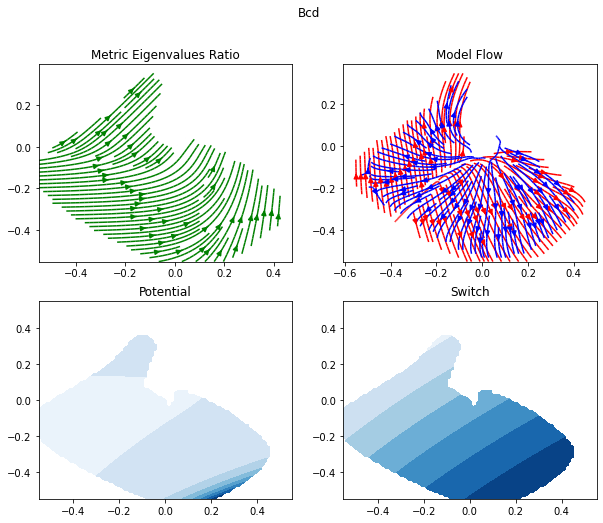

In [16]:
fig, axs = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(10)
fig.suptitle(data_type)

H1a, H2a = get_data_func_Fly(min_func.metric_nn, H1, H2, size = 100, ma = H1dot.mask)
axs[0,0].streamplot(H1, H2, H1a, H2a, density=2, color = 'g')
axs[0,0].set_title('Metric Eigenvalues Ratio')

H1a, H2a = get_data_func_Fly(min_func, H1, H2, size = 100, ma = H1dot.mask)
axs[0,1].streamplot(H1, H2, H1a, H2a, density=2, color = 'r')
axs[0,1].streamplot(H1, H2, H1dot, H2dot, density=2, color = 'b')
axs[0,1].set_title('Model Flow')

h_mask = get_data_V_Fly(min_func, H1, H2, ma = H1dot.mask, num = None, flip = False)
axs[1,0].contourf(H1, H2, h_mask, cmap='Blues', )
axs[1,0].set_title('Potential')

size = len(H1)
a = min_func.switch(torch.Tensor(np.stack([H1, H2], -1).reshape(size*size, 2)))
a = a.cpu().detach().numpy()
h = a.reshape(size,size)
h_mask = np.ma.masked_array(h, mask=H1dot.mask)

axs[1,1].contourf(H1, H2, h_mask, cmap='Blues')
axs[1,1].set_title('Switch')

fig.savefig('Plots_'+ data_type + '.png')

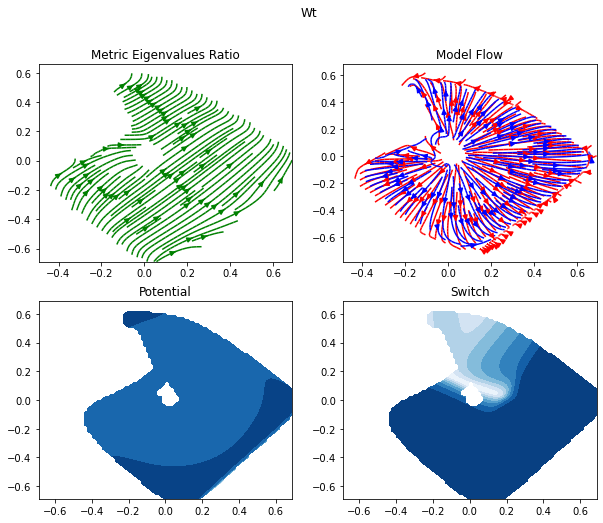

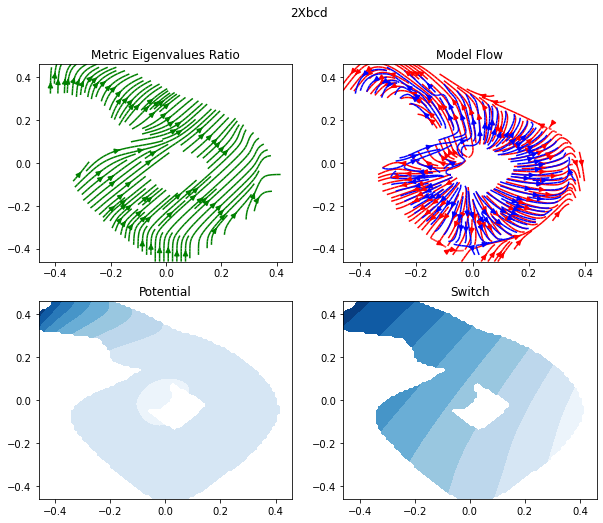

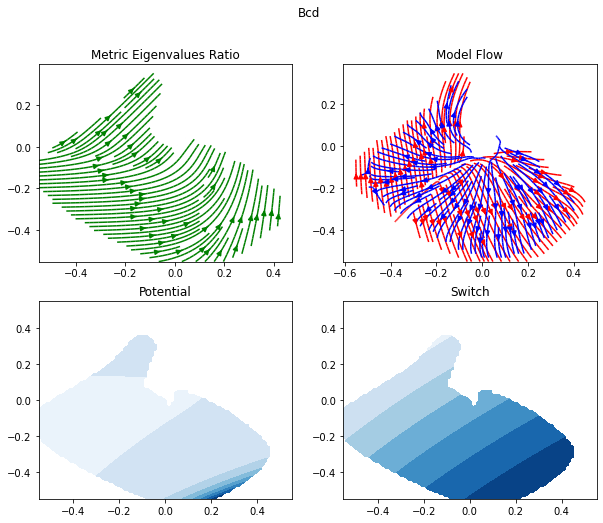

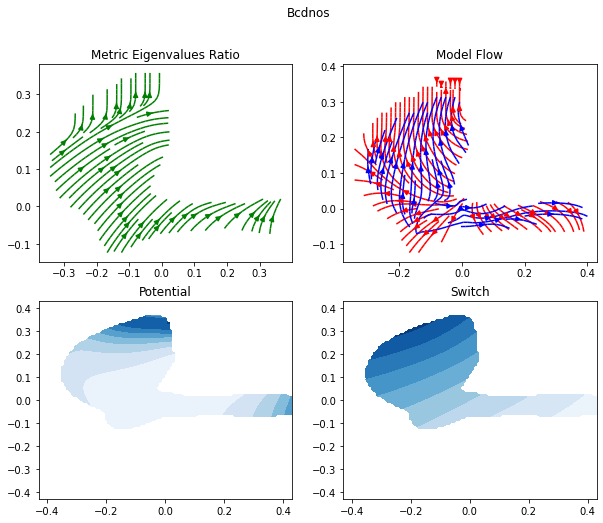

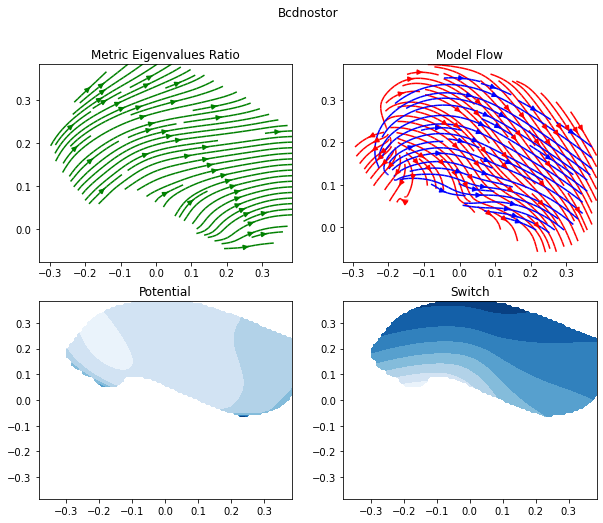

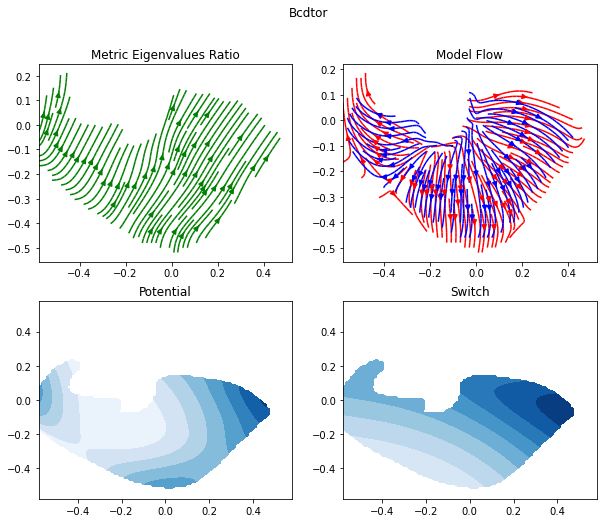

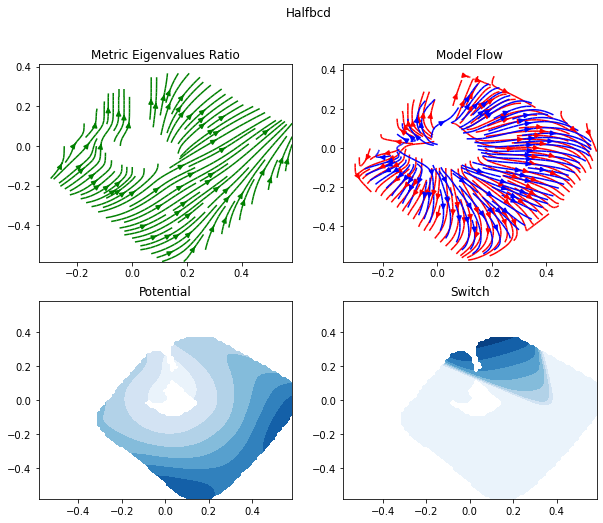

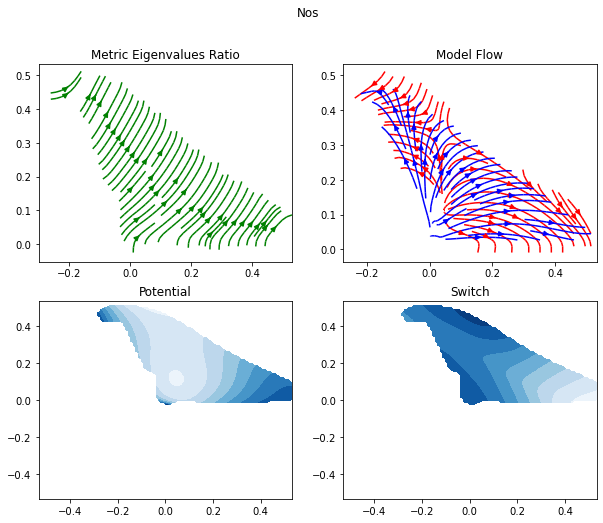

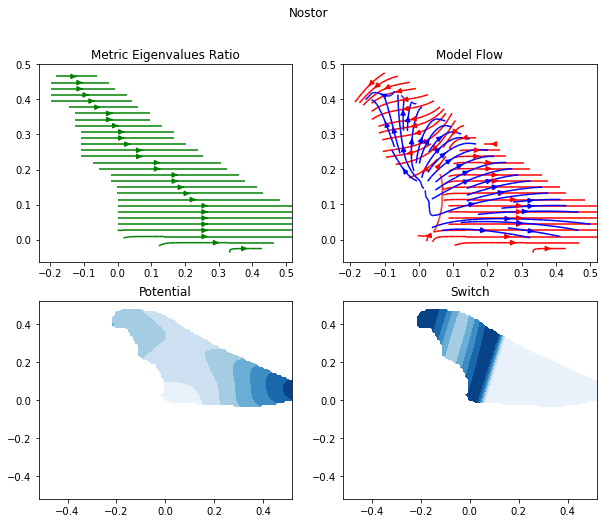

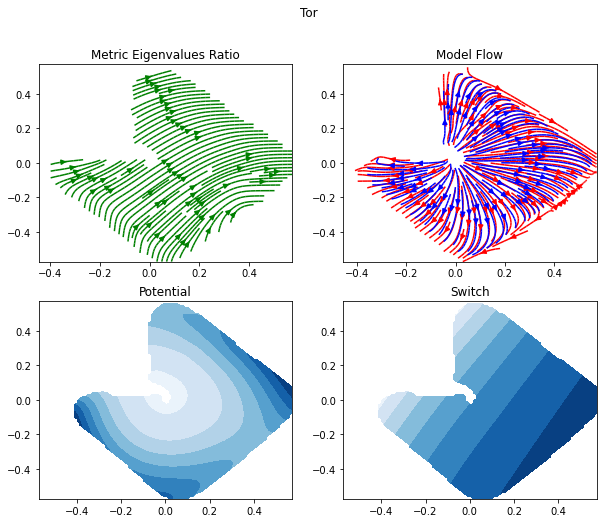

In [18]:
for file in os.listdir():
    if file.endswith(".obj"):
        infile = open(file.title(),'rb')
        H1, H2, H1dot, H2dot = pickle.load(infile)
        infile.close()

        Hdot = np.ma.stack([H1dot, H2dot], 2)
        H_coord = np.ma.stack([H1, H2], 2)

        V1, N1 = extractData(H1dot, H1)
        V2, N2 = extractData(H2dot, H2)

        N = np.concatenate((N1, N2), 1)
        V = np.concatenate((V1, V2), 1)

        N = torch.from_numpy(N).float()
        V = torch.from_numpy(V).float()

        V_norm = (V-torch.mean(V))/torch.std(V)


        data_type = file.title().replace("Gap_Genes_2Dspace_Flow_",  "")
        data_type = data_type.replace(".Obj", "")
        min_func = torch.load('min_func_' + data_type + '.pt')

        fig, axs = plt.subplots(2, 2)
        fig.set_figheight(8)
        fig.set_figwidth(10)
        fig.suptitle(data_type)

        H1a, H2a = get_data_func_Fly(min_func.metric_nn, H1, H2, size = 100, ma = H1dot.mask)
        axs[0,0].streamplot(H1, H2, H1a, H2a, density=2, color = 'g')
        axs[0,0].set_title('Metric Eigenvalues Ratio')

        H1a, H2a = get_data_func_Fly(min_func, H1, H2, size = 100, ma = H1dot.mask)
        axs[0,1].streamplot(H1, H2, H1a, H2a, density=2, color = 'r')
        axs[0,1].streamplot(H1, H2, H1dot, H2dot, density=2, color = 'b')
        axs[0,1].set_title('Model Flow')

        h_mask = get_data_V_Fly(min_func, H1, H2, ma = H1dot.mask, num = None, flip = False)
        axs[1,0].contourf(H1, H2, h_mask, cmap='Blues', )
        axs[1,0].set_title('Potential')

        size = len(H1)
        a = min_func.switch(torch.Tensor(np.stack([H1, H2], -1).reshape(size*size, 2)))
        a = a.cpu().detach().numpy()
        h = a.reshape(size,size)
        h_mask = np.ma.masked_array(h, mask=H1dot.mask)

        axs[1,1].contourf(H1, H2, h_mask, cmap='Blues')
        axs[1,1].set_title('Switch')

        fig.savefig('Plots_'+ data_type + '2.png')